In [25]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

# Visualizing Data

In [2]:
def find_missing(serie):
    dates = pd.date_range(start=serie.index.min(), end=serie.index.max(), freq="H")
    missing_dates = []
    
    continous_part = []
    
    start = serie.index.min()
    end = serie.index.min()
    for date in dates:
        if not date in serie.index:
            missing_dates.append(date)
            continous_part.append((start,end))
            start = date
            end = date
        else:
            end = date

    if len(missing_dates) == 0:
        print("No missing values")
        return serie.index.min(), serie.index.max()
    
    plt.hist(missing_dates)
    plt.show()
    
    missing = pd.DataFrame(missing_dates)
    missing.index = missing[0]
    
    length = []
    for start,end in continous_part:
        length.append((end - start).days)
    best_start,best_end = continous_part[np.argmax(length)]
    print(best_start,best_end)
    
    return best_start,best_end

FILE:  meteo.csv


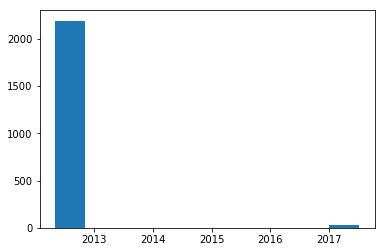

2012-09-28 10:00:00 2014-12-20 23:00:00
No missing values
Contiguous data length:  19525
FILE:  lagunillas.csv


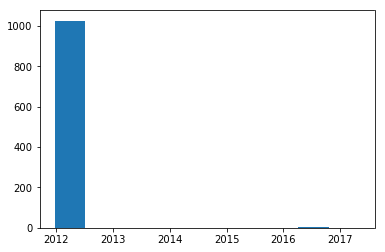

2012-10-25 17:00:00 2015-07-20 15:00:00
No missing values
Contiguous data length:  23950
FILE:  lota_r.csv


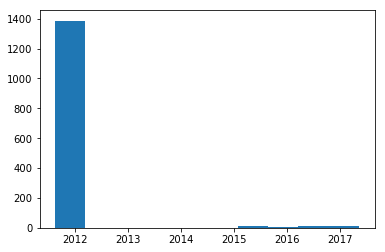

2012-04-30 17:00:00 2015-03-28 07:00:00
No missing values
Contiguous data length:  25478
FILE:  lota_u.csv


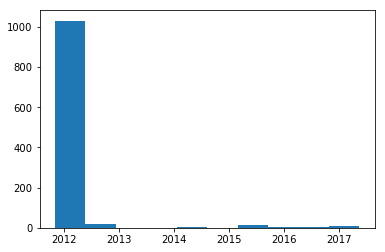

2012-11-07 08:00:00 2014-03-14 10:00:00
No missing values
Contiguous data length:  11810


In [3]:
# Loading data
best_length = 0
for file in ["meteo.csv","lagunillas.csv","lota_r.csv","lota_u.csv"]:
    data = pd.read_csv('data/'+file, names=["t","ws"],index_col="t")
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                data.index=pd.to_datetime(data.index)
    print("FILE: ", file)
    start,end = find_missing(data)
    data_filtered = data[start:end]
    if len(data_filtered) > best_length:
        best_data = data_filtered
    find_missing(data_filtered)
    print("Contiguous data length: ",len(data_filtered))

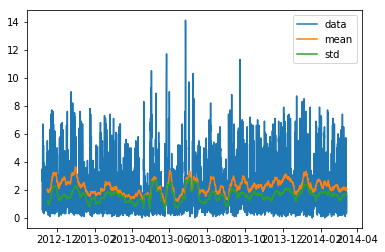

In [14]:
mean = best_data.rolling(window=200,center=False).mean()
std = best_data.rolling(window=200,center=False).std()

plt.plot(best_data)
plt.plot(mean)
plt.plot(std)
plt.legend(["data","mean", "std"])

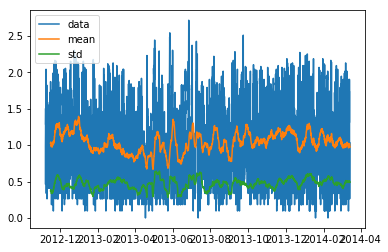

In [15]:
log_data = np.log(best_data+1)
mean = log_data.rolling(window=200,center=False).mean()
std = log_data.rolling(window=200,center=False).std()

plt.plot(log_data)
plt.plot(mean)
plt.plot(std)
plt.legend(["data","mean", "std"])

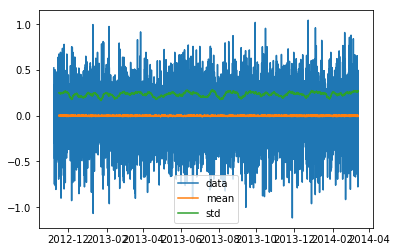

In [16]:
diff_log = pd.DataFrame(np.diff(np.log(best_data+1),axis=0))
diff_log.index = best_data.index[:-1]
mean = diff_log.rolling(window=200,center=False).mean()
std = diff_log.rolling(window=200,center=False).std()

plt.plot(diff_log)
plt.plot(mean)
plt.plot(std)
plt.legend(["data","mean", "std"])

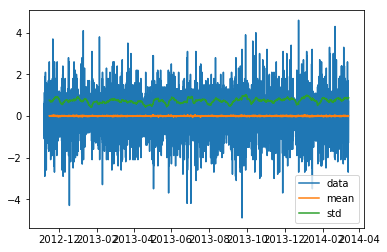

In [17]:
diff_data = pd.DataFrame(np.diff(best_data,axis=0))
diff_data.index = best_data.index[:-1]
mean = diff_data.rolling(window=200,center=False).mean()
std = diff_data.rolling(window=200,center=False).std()

plt.plot(diff_data)
plt.plot(mean)
plt.plot(std)
plt.legend(["data","mean", "std"])

In [102]:
from pandas.plotting import autocorrelation_plot

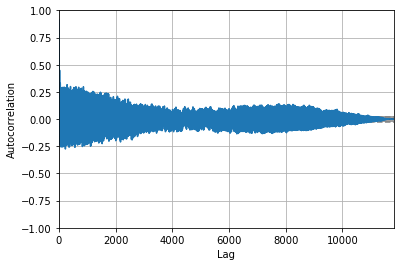

In [103]:
autocorrelation_plot(best_data)

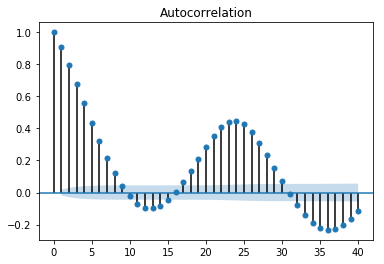

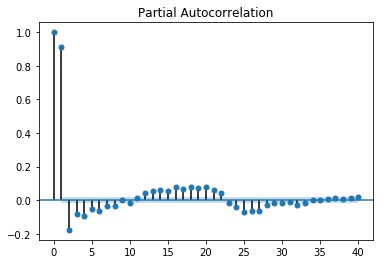

In [18]:
sm.graphics.tsa.plot_acf(best_data, lags=40)
sm.graphics.tsa.plot_pacf(best_data,lags=40)
print()

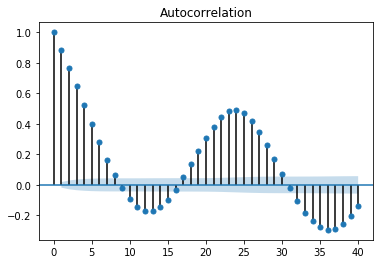

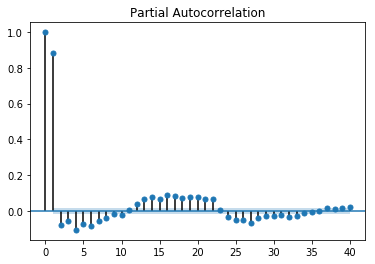

In [19]:
sm.graphics.tsa.plot_acf(log_data, lags=40)
sm.graphics.tsa.plot_pacf(log_data,lags=40)
print()

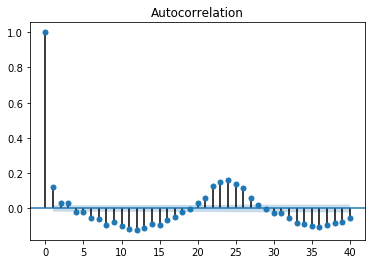

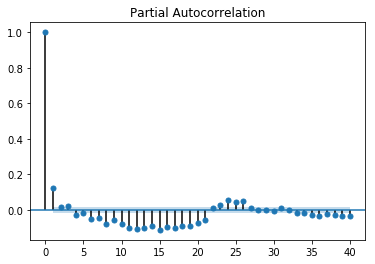

In [20]:
sm.graphics.tsa.plot_acf(diff_data, lags=40)
sm.graphics.tsa.plot_pacf(diff_data,lags=40)
print()

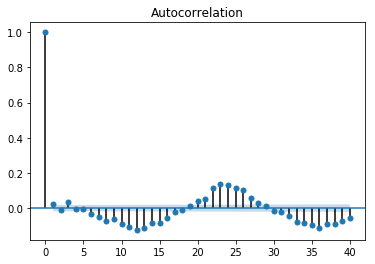

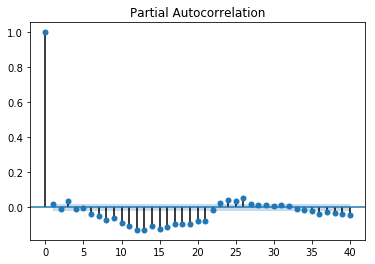

In [21]:
sm.graphics.tsa.plot_acf(diff_log, lags=40)
sm.graphics.tsa.plot_pacf(diff_log,lags=40)
print()

To determine the ARIMA parameters (p,d,q) we use ACF and PACF
* p: comes from PACF
* d: 1 if is diff
* q: comes from ACF

From the previous plots we will use
* (3,1,3)

In [38]:
data_len = len(best_data)
train_perc = 0.9
train_data = int(0.9*data_len)
train = best_data[:train_data]
test = best_data[train_data:]

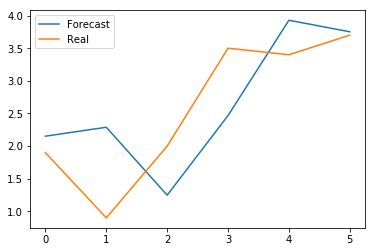

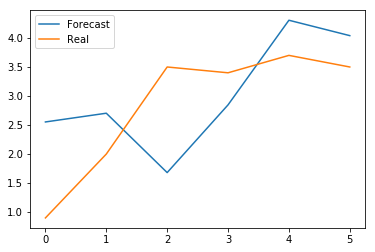

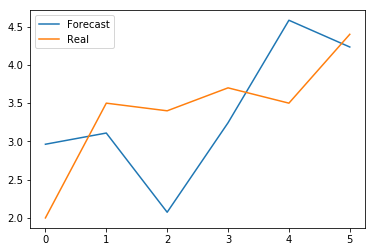

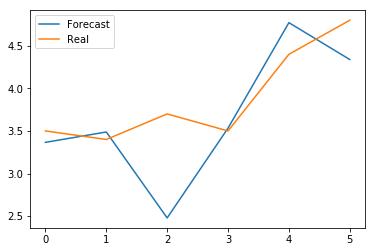

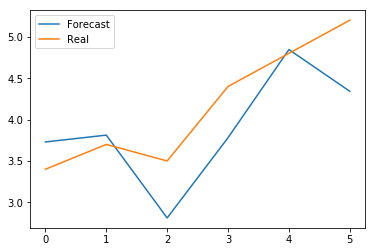

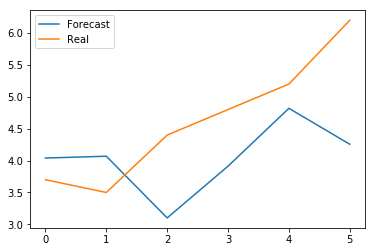

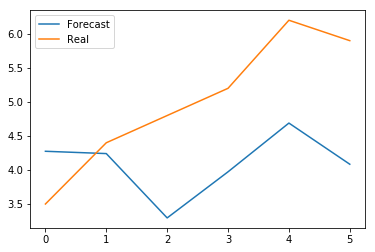

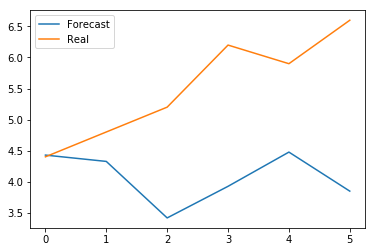

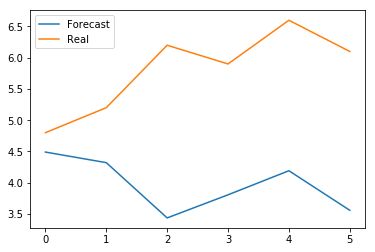

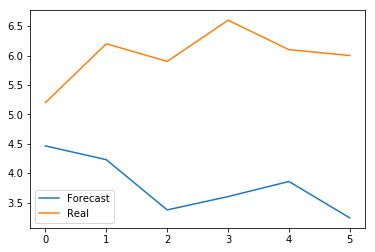

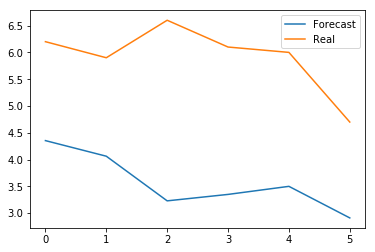

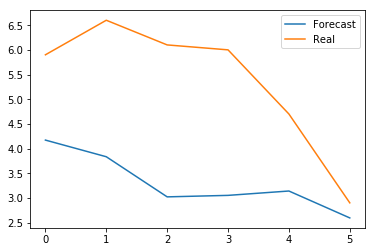

In [52]:
for i in range(12):
    plt.plot(forecast[:,i])
    plt.plot(wind_speed[:,i])
    plt.legend(["Forecast","Real"])
    plt.show()

In [53]:
from multiprocessing import Pool

In [111]:
def train_arima(args):
    data,test,params,i = args
    model = sm.tsa.ARIMA(data,parameters)
    result = model.fit()
    pred = result.forecast(steps=12)
    return pred[0]

In [126]:
pool = Pool(4)

parameters = (3,1,3)
data = train
wind_speed = []

args = []
for i,value in enumerate(test.iterrows()):
    if i == len(test)- 12:
        break
    args.append((data,test,parameters,i))
    wind_speed.append(test[i:i+12].values.reshape((-1,)))

    index, val = value
    data = data.append(val)
    if i == 5:
        break
forecast = np.array(pool.map(train_arima,args))
wind_speed = np.array(wind_speed)

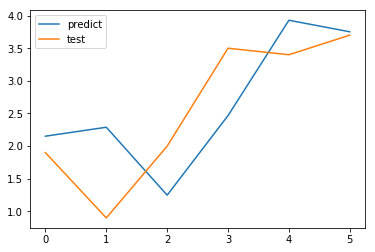

In [127]:
plt.plot(forecast[:,0],label="predict")
plt.plot(wind_speed[:,0],label="test")
plt.legend()